In [1]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("train_dataset1.csv")  # merge msf + medusa

print(df.head())
print("\nDataset shape:", df.shape)

   window_id           src_ip           dst_ip  mean_inter_arrival  \
0          0  192.168.153.138  192.168.153.141            0.280619   
1          1  192.168.153.138  192.168.153.141            0.078832   
2          2  192.168.153.138  192.168.153.141            0.008539   
3          3  192.168.153.138  192.168.153.141            0.409017   
4          4  192.168.153.138  192.168.153.141            0.093615   

   std_inter_arrival  burstiness  syn_count  rst_count  syn_ratio  rst_ratio  \
0           1.596719    5.689983          2          0   0.055556        0.0   
1           0.193134    2.449935          0          0   0.000000        0.0   
2           0.017259    2.021072          2          0   0.076923        0.0   
3           1.184510    2.895994          0          0   0.000000        0.0   
4           0.208240    2.224415          0          0   0.000000        0.0   

   zero_payload_ratio  flow_count_per_window  label  
0            0.333333                      1

In [3]:
FEATURES = [
"mean_inter_arrival",
"std_inter_arrival",
"burstiness",
"syn_count",
"rst_count",
"syn_ratio",
# "rst_ratio",
"zero_payload_ratio",
"flow_count_per_window"
]


LABEL = "label"
X = df[FEATURES]
y = df[LABEL]
print("Normal flows:", sum(y == 0))
print("Brute-force flows:", sum(y == 1))

Normal flows: 1512
Brute-force flows: 4298


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
stratify=y,
random_state=42
)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Train samples: 4648
Test samples: 1162


In [5]:
pipeline = Pipeline([
("scaler", StandardScaler()),
("rf", RandomForestClassifier(
n_estimators=200,
max_depth=12,
min_samples_leaf=5,
class_weight="balanced",
random_state=42,
n_jobs=-1
))
])


In [6]:
pipeline.fit(X_train, y_train)
print("Model training completed")

Model training completed


In [7]:
y_pred = pipeline.predict(X_test)


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))



Classification Report:

              precision    recall  f1-score   support

           0     0.9933    0.9768    0.9850       302
           1     0.9919    0.9977    0.9948       860

    accuracy                         0.9923      1162
   macro avg     0.9926    0.9872    0.9899      1162
weighted avg     0.9923    0.9923    0.9922      1162



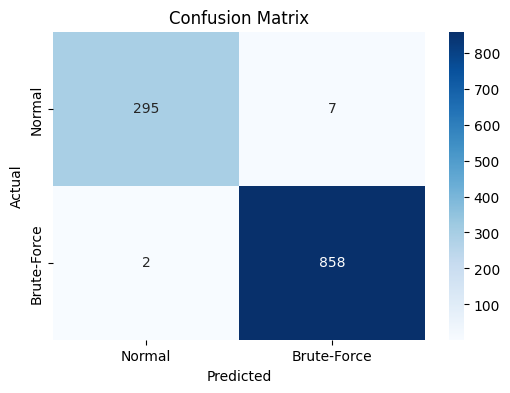

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Brute-Force'], yticklabels=['Normal', 'Brute-Force'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [9]:
rf = pipeline.named_steps["rf"]
importances = rf.feature_importances_


importance_df = pd.DataFrame({
"Feature": FEATURES,
"Importance": importances
}).sort_values(by="Importance", ascending=False)


importance_df

,Feature,Importance
7,flow_count_per_window,0.409245
6,zero_payload_ratio,0.162732
0,mean_inter_arrival,0.126231
5,syn_ratio,0.111513
1,std_inter_arrival,0.108194
3,syn_count,0.046848
2,burstiness,0.024055
4,rst_count,0.011182


In [10]:
model_output = "ssh_ids_model.pkl"

joblib.dump({
"model": pipeline,
"features": FEATURES
}, model_output)

print(f"Model saved to {model_output}")


Model saved to ssh_ids_model.pkl


In [11]:
model = joblib.load(model_output)

In [16]:
import numpy as np
mean_ia = 0.005
std_ia = 0.002
burstiness = 0.8
syn_count = 50
rst_count = 5
syn_ratio = 0.9
# rst_ratio = 0.1
zero_payload_ratio = 0.7
flow_count_per_window = 100
features = np.array([[
                    mean_ia,
                    std_ia,
                    burstiness,
                    syn_count,
                    rst_count,
                    syn_ratio,
                    # rst_ratio,
                    zero_payload_ratio,
                    flow_count_per_window
                ]])

In [20]:
model

{'model': Pipeline(steps=[('scaler', StandardScaler()),
                 ('rf',
                  RandomForestClassifier(class_weight='balanced', max_depth=12,
                                         min_samples_leaf=5, n_estimators=200,
                                         n_jobs=-1, random_state=42))]),
 'features': ['mean_inter_arrival',
  'std_inter_arrival',
  'burstiness',
  'syn_count',
  'rst_count',
  'syn_ratio',
  'zero_payload_ratio',
  'flow_count_per_window']}

In [ ]:
prob = model.predict_proba(features)[0][1]
print(f"Brute-force attack probability: {prob:.4f}")

AttributeError: 'dict' object has no attribute 'RandomForestClassifier'

In [24]:
model_bundle = joblib.load(model_output)

if isinstance(model_bundle, dict):
    model = model_bundle["model"]
    feature_names = model_bundle.get("feature_names", [])
    trained_window = model_bundle.get("window_size", "unknown")
else:
    model = model_bundle
    feature_names = []
    trained_window = "unknown"


In [25]:
prob = model.predict_proba(features)[0][1]

C:\Users\omarh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
if hasattr(model, "n_features_in_"):
    if features.shape[1] != model.n_features_in_:
        print("[!] FEATURE MISMATCH — skipping window")
        


In [31]:
model_bundle = joblib.load("ssh_ids_model.pkl")

model = model_bundle["model"]
FEATURES = model_bundle["features"]

print("Model loaded:", type(model))
print("Expected features:")
for i, f in enumerate(FEATURES):
    print(f"{i+1}. {f}")


Model loaded: <class 'sklearn.pipeline.Pipeline'>
Expected features:
1. mean_inter_arrival
2. std_inter_arrival
3. burstiness
4. syn_count
5. rst_count
6. syn_ratio
7. zero_payload_ratio
8. flow_count_per_window


In [41]:
normal_sample = {
    "mean_inter_arrival": 0.4,
    "std_inter_arrival": 0.1,
    "burstiness": 0.25,
    "syn_count": 3,
    "rst_count": 0,
    "syn_ratio": 0.15,
    "zero_payload_ratio": 0.2,
    "flow_count_per_window": 2
}
import pandas as pd


X_normal = pd.DataFrame(
    [[normal_sample[f] for f in FEATURES]],
    columns=FEATURES
)

model.predict(X_normal), model.predict_proba(X_normal)


(array([1]), array([[0.30003839, 0.69996161]]))